# 6장. 알고리즘 체인과 파이프라인

*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/intro_ml_with_python_2nd_revised/blob/main/06-algorithm-chains-and-pipelines.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/intro_ml_with_python_2nd_revised/blob/main/06-algorithm-chains-and-pipelines.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

이 노트북은 맷플롯립 그래프에 한글을 쓰기 위해 나눔 폰트를 사용합니다. 코랩의 경우 다음 셀에서 나눔 폰트를 직접 설치합니다.

In [19]:
%pip install koreanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Text(0.5, 0, '날짜')

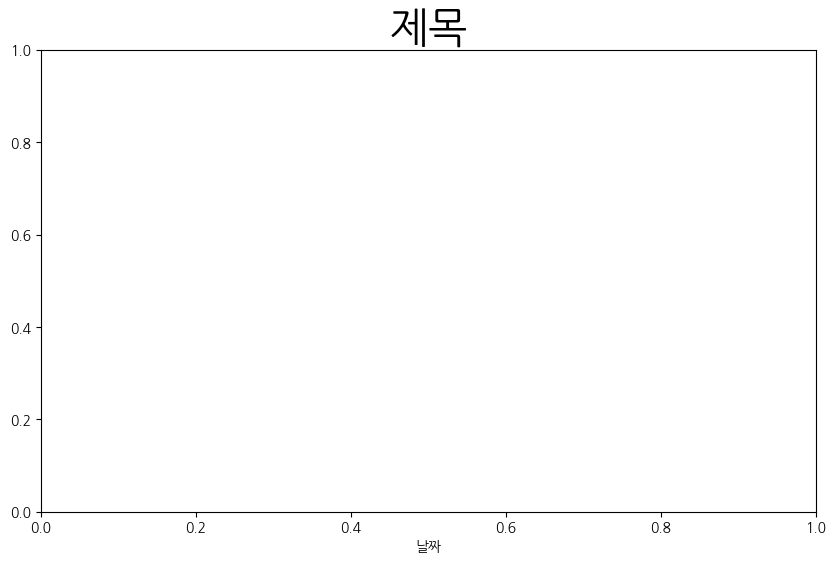

In [20]:
%matplotlib inline
import preamble
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

plt.figure(figsize=(10,6))
plt.title('제목', fontsize=30)
plt.xlabel('날짜', fontsize=10)

In [21]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다
scaler = MinMaxScaler().fit(X_train)

In [22]:
# 훈련 데이터의 스케일을 조정합니다
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


## 6.1 데이터 전처리와 매개변수 선택

GridSearchCV는 주어진 param_grid에 따라 다양한 하이퍼파라미터 조합을 시도합니다.
각 하이퍼파라미터 조합에 대해 5겹 교차 검증을 수행하여 평균 성능 점수를 계산합니다.
가장 높은 점수를 얻는 하이퍼파라미터 조합을 선택합

In [23]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5) #5겹 교차 검증
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


In [24]:
import mglearn

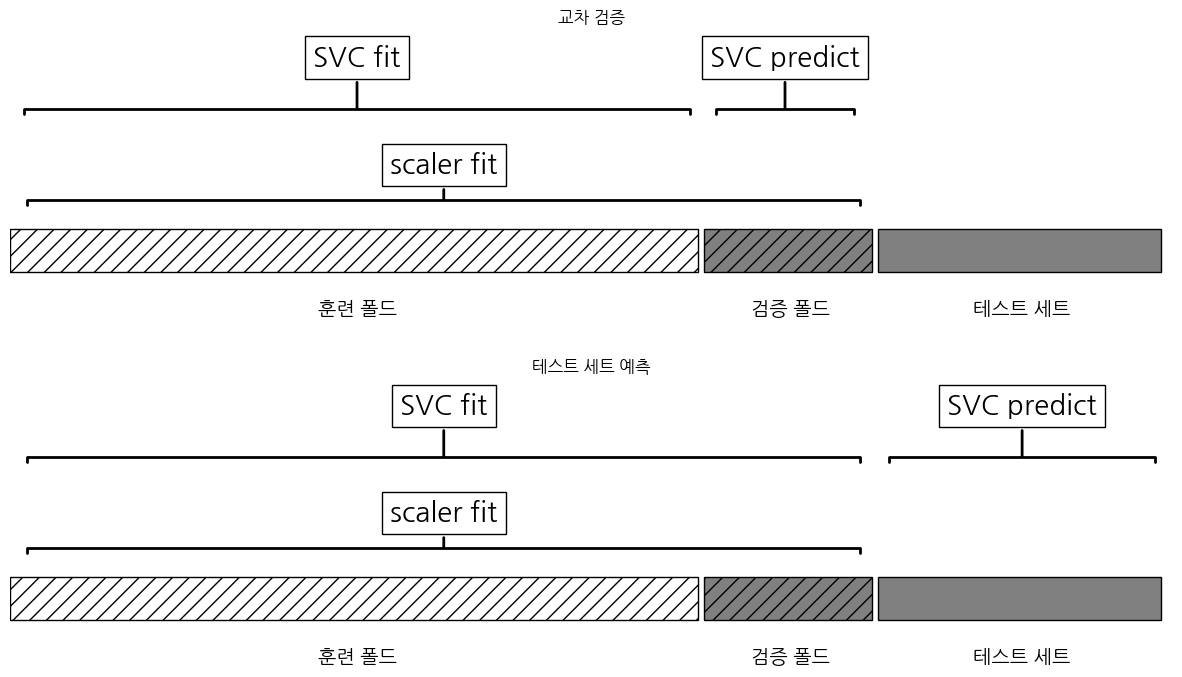

In [25]:
mglearn.plots.plot_improper_processing()

## 6.2 파이프라인 구축하기

In [26]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [27]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [28]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


## 6.3 그리드 서치에 파이프라인 적용하기

In [29]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [30]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


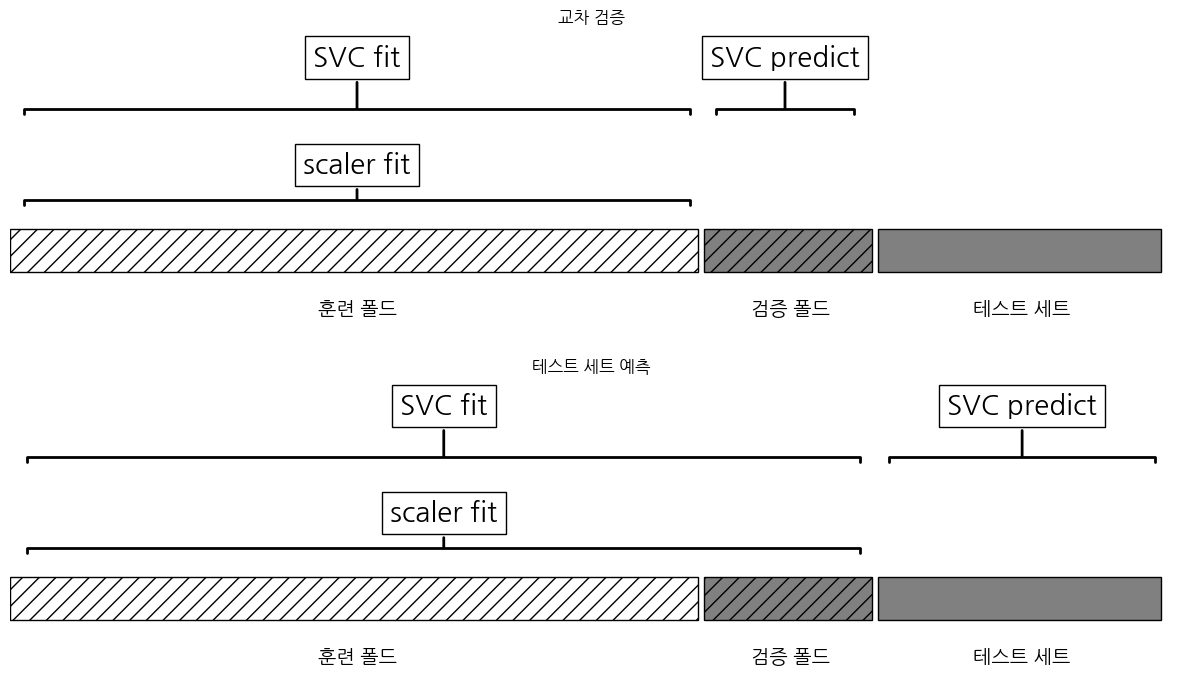

In [31]:
mglearn.plots.plot_proper_processing()

내부 동작:
훈련 세트와 검증 세트로 나뉩니다:

5겹 교차 검증이므로 훈련 데이터를 5개의 fold로 분할.
각 반복에서 1개 fold는 검증 세트, 나머지 4개 fold는 훈련 세트로 사용.
훈련 fold에 대해 scaler.fit() 호출:

훈련 데이터(fit fold)에 대해서만 StandardScaler가 fit()되고 transform()이 적용됩니다.
검증 fold에는 **훈련 fold에서 학습된 스케일링 매개변수(mean, std)**를 적용하여 transform()만 수행됩니다.
검증 fold에 절대 fit() 호출 안 됨:

검증 fold는 모델 평가용 데이터이기 때문에 스케일링 파라미터(mean, std)가 검증 데이터에 영향을 주지 않도록 transform()만 수행합니다.
중요한 이유
검증 데이터에 fit()이 수행되면, 검증 데이터가 훈련 데이터의 정보에 간접적으로 노출되기 때문에 교차 검증 결과가 왜곡될 수 있습니다.
파이프라인을 사용하면 이러한 문제를 자동으로 방지할 수 있습니다.


아래와 같이 StandardScaler를 파이프라인 밖에서 사용하면 검증 fold가 훈련 데이터 정보에 영향을 받을 수 있습니다:

이 경우, 검증 데이터가 scaler.fit()에 의해 이미 스케일링 파라미터(mean, std) 정보를 간접적으로 공유하게 됩니다.
결과적으로 교차 검증의 평가가 신뢰성을 잃게 됩니다.

In [32]:
### 비실행 > 교재 416 페이지 코드임
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 전체 X_train에 대해 fit
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

ValueError: Invalid parameter 'svm' for estimator SVC(). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

왜 검증 폴드에서 fit()이 되지 않는가?
GridSearchCV는 각 fold에 대해 다음 단계를 수행합니다:

데이터를 훈련 세트와 검증 세트로 나눕니다.
훈련 세트에 대해서만 Pipeline의 각 스텝에서 fit()을 호출합니다.
즉, StandardScaler는 훈련 세트에서만 평균과 표준편차를 계산합니다.
검증 세트에서는 StandardScaler.transform()만 호출하여 훈련 세트의 기준을 적용합니다.
따라서, 검증 데이터에 새로운 fit()이 적용되지 않습니다. 이로 인해 데이터 누출 문제가 방지됩니다.



In [15]:
import numpy as np
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))
# 중요한 점은 X와 y 사이에 실제로 의미 있는 관계가 없다는 것입니다.
# 이는 X의 대부분의 특징이 y를 예측하는 데 도움이 되지 않는다는 뜻입니다.

In [11]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
# SelectPercentile는 f_regression(F-통계량 기반)을 사용해 각 특징과 타깃 y 간의 통계적 연관성을 계산합니다.
X_selected = select.transform(X)
print("X_selected.shape:", X_selected.shape)

X_selected.shape: (100, 500)


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수 (릿지): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수 (릿지): 0.91


교차 검증에서 높은 점수가 나오는 이유
교차 검증의 데이터 분할:

cross_val_score는 데이터를 훈련 세트와 검증 세트로 나눕니다.
SelectPercentile는 이 과정에서 fit()된 X_selected를 사용하지 않습니다. 따라서 교차 검증 과정 자체는 올바르게 수행되지만, 이미 선택된 특징(우연히 높은 상관관계를 가진 특징)에서 높은 점수를 반환하게 됩니다.
과적합의 가능성:

특징 선택 과정에서 이미 y와의 관계를 고려하여 특징을 골랐기 때문에, X_selected는 검증 데이터에서도 우연히 높은 성능을 내는 경향이 있습니다.
이는 실제 모델 성능을 과대평가한 결과입니다.

In [18]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 점수 (파이프라인): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수 (파이프라인): -0.25


Pipeline은 교차 검증(cross_val_score) 과정에서 다음 단계를 처리합니다:

데이터를 훈련 세트와 검증 세트로 나눕니다.
훈련 세트에서만:
SelectPercentile로 특징을 선택합니다.
Ridge를 학습시킵니다.

검증 세트에서는:
훈련 세트에서 선택된 특징과 동일한 기준을 사용하여 검증 데이터를 변환(transform())합니다.
검증 세트에 대해 모델을 평가합니다.


주요 원인
훈련 세트와 검증 세트 간의 불일치:
SelectPercentile는 훈련 데이터에서 y와 높은 상관관계를 가진 특징만 선택합니다. 하지만, 검증 데이터에서는 이러한 특징이 랜덤 상관관계로 인해 타겟 y를 예측하지 못합니다.
이는 모델이 훈련 데이터에 과적합되었음을 의미합니다.

## 6.4 파이프라인 인터페이스

In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [17]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

# 사용자 정의 Pipeline 클래스
class CustomPipeline:
    def __init__(self, steps):
        """
        steps: [(name1, estimator1), (name2, estimator2), ...]
        - 각 단계에 이름과 변환기/모델을 튜플로 전달
        """
        self.steps = steps

    def fit(self, X, y):
        """
        모든 단계에 대해 fit()과 transform()을 반복 실행
        """
        X_transformed = X
        for name, estimator in self.steps[:-1]:
            # 마지막 단계 전까지 fit_transform 호출
            X_transformed = estimator.fit_transform(X_transformed, y)
        # 마지막 단계의 모델은 fit만 수행
        self.steps[-1][1].fit(X_transformed, y)
        return self

    def predict(self, X):
        """
        변환 단계를 거친 후 최종 모델의 predict() 호출
        """
        X_transformed = X
        for name, estimator in self.steps[:-1]:
            X_transformed = estimator.transform(X_transformed)
        return self.steps[-1][1].predict(X_transformed)

# 데이터 생성
X, y = make_regression(n_samples=100, n_features=20, noise=0.1, random_state=42)

# CustomPipeline에 사용할 단계 정의
steps = [
    ("scaler", StandardScaler()),               # 데이터 표준화
    ("feature_selection", SelectKBest(f_regression, k=10)),  # 상위 10개 특징 선택
    ("regressor", Ridge(alpha=1.0))             # 릿지 회귀
]

# Pipeline 생성
pipeline = CustomPipeline(steps)

# 학습
pipeline.fit(X, y)

# 예측
predictions = pipeline.predict(X)

# 결과 출력
print("첫 번째 5개 예측값:", predictions[:5])


첫 번째 5개 예측값: [  98.333 -254.254    3.578  122.567   16.413]


CustomPipeline 클래스

steps는 단계별 이름과 변환기/모델 객체를 튜플로 전달받습니다.

fit() 메서드:
마지막 단계를 제외한 모든 단계에서 fit_transform()을 호출하여 데이터를 변환합니다.
마지막 단계에서는 fit()만 호출하여 모델을 학습합니다.

predict() 메서드:
변환 단계를 순차적으로 거친 후 최종 모델에서 predict()를 호출합니다.

#### 파이프라인 그리기

In [23]:
from sklearn import set_config

set_config(display='diagram')
pipe

Pipeline(steps=[('select',
                 SelectPercentile(percentile=5,
                                  score_func=<function f_regression at 0x000001C9AF892340>)),
                ('ridge', Ridge())])

### 6.4.1 `make_pipleline`을 사용한 파이프라인 생성

In [23]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [26]:
pipe_long

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC(C=100))])

In [27]:
pipe_short

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))])

In [28]:
print("파이프라인 단계:\n", pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n", pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [30]:
pipe

Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('standardscaler-2', StandardScaler())])

### 6.4.2 단계 속성에 접근하기

In [ ]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data) # cancer 데이터는 30개의 특성 가짐
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


PCA가 추출한 주성분의 개수: n_components=2 → 2개의 주성분

원래 특징 공간의 차원: 30

따라서, components_의 크기는 (2, 30)입니다.
각 행: 주성분 1과 주성분 2를 나타냄.
각 열: 30개의 원래 특징 공간에서 각 주성분의 방향(가중치)을 나타냄.


### 6.4.3 그리드 서치 안의 파이프라인의 속성에 접근하기

In [32]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [33]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [35]:
print("최상의 모델:\n", grid.best_estimator_)

최상의 모델:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [36]:
print("로지스틱 회귀 단계:\n",
      grid.best_estimator_.named_steps["logisticregression"])

로지스틱 회귀 단계:
 LogisticRegression(C=1, max_iter=1000)


In [37]:
print("로지스틱 회귀 계수:\n",
      grid.best_estimator_.named_steps["logisticregression"].coef_)

로지스틱 회귀 계수:
 [[-0.448 -0.346 -0.417 -0.529 -0.158  0.603 -0.718 -0.784  0.048  0.275
  -1.295  0.053 -0.691 -0.919 -0.148  0.461 -0.126 -0.103  0.428  0.715
  -1.085 -1.093 -0.851 -1.041 -0.728  0.077 -0.836 -0.649 -0.649 -0.43 ]]


## 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

In [34]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
# 보스턴 주택 데이터셋이 1.2 버전에서 삭제되므로 직접 다운로드합니다.
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [35]:
data[:5]

array([[  0.006,  18.   ,   2.31 ,   0.   ,   0.538,   6.575,  65.2  ,
          4.09 ,   1.   , 296.   ,  15.3  , 396.9  ,   4.98 ],
       [  0.027,   0.   ,   7.07 ,   0.   ,   0.469,   6.421,  78.9  ,
          4.967,   2.   , 242.   ,  17.8  , 396.9  ,   9.14 ],
       [  0.027,   0.   ,   7.07 ,   0.   ,   0.469,   7.185,  61.1  ,
          4.967,   2.   , 242.   ,  17.8  , 392.83 ,   4.03 ],
       [  0.032,   0.   ,   2.18 ,   0.   ,   0.458,   6.998,  45.8  ,
          6.062,   3.   , 222.   ,  18.7  , 394.63 ,   2.94 ],
       [  0.069,   0.   ,   2.18 ,   0.   ,   0.458,   7.147,  54.2  ,
          6.062,   3.   , 222.   ,  18.7  , 396.9  ,   5.33 ]])

In [36]:
# 보스턴 주택 데이터셋의 특성 이름
feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

# 특성 이름 출력
print("특성 이름:")
for i, name in enumerate(feature_names):
    print(f"{i + 1}. {name}")

특성 이름:
1. CRIM
2. ZN
3. INDUS
4. CHAS
5. NOX
6. RM
7. AGE
8. DIS
9. RAD
10. TAX
11. PTRATIO
12. B
13. LSTAT


CRIM (per capita crime rate by town)

해당 지역에서 1인당 발생한 범죄율.
ZN (proportion of residential land zoned for lots over 25,000 sq.ft.)

25,000 평방피트(약 2322m²) 이상의 대규모 주거용 부지 비율.
INDUS (proportion of non-retail business acres per town)

비소매업 상업 구역이 차지하는 면적 비율.
CHAS (Charles River dummy variable)

찰스강 인접 여부를 나타내는 이진 변수.
1: 찰스강 인접
0: 찰스강과 인접하지 않음.
NOX (nitric oxides concentration, parts per 10 million)

대기 중 질소산화물 농도 (10ppm 단위).
RM (average number of rooms per dwelling)

주택당 평균 방 수.
AGE (proportion of owner-occupied units built prior to 1940)

1940년 이전에 건설된 자가 주택의 비율.
DIS (weighted distances to five Boston employment centres)

보스턴 주요 고용센터 5곳과의 가중 거리.
RAD (index of accessibility to radial highways)

방사형 고속도로 접근성 지수.
TAX (full-value property-tax rate per $10,000)

재산세율 ($10,000당).
PTRATIO (pupil-teacher ratio by town)

지역별 학생-교사 비율.
B (1000(Bk - 0.63)^2 where Bk is the proportion of Black residents by town)

지역별 흑인 인구 비율을 나타내는 계산된 지표.
LSTAT (percentage of lower status of the population)

낮은 경제적 지위를 가진 인구 비율

In [38]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [39]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs = 1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

TypeError: Only length-1 arrays can be converted to Python scalars

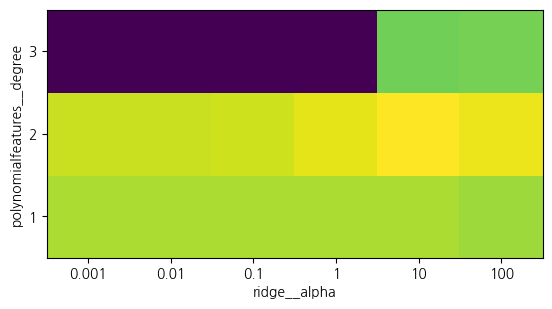

In [40]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)
plt.show() # 책에는 없음

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# 예제 param_grid
param_grid = {
    "polynomialfeatures__degree": [1, 2, 3],
    "ridge__alpha": [0.1, 1, 10]
}

# 조합 수 확인
total_combinations = len(param_grid["polynomialfeatures__degree"]) * len(param_grid["ridge__alpha"])
print("총 조합 수:", total_combinations)  # 출력: 9


총 조합 수: 9


In [50]:
# 'mean_test_score'의 길이를 확인
mean_test_score = grid.cv_results_['mean_test_score']
print("mean_test_score 크기:", mean_test_score.shape)

# reshape 크기 수정
mean_test_score_reshaped = mean_test_score.reshape(
    len(param_grid["polynomialfeatures__degree"]),
    len(param_grid["ridge__alpha"])
)


mean_test_score 크기: (18,)


ValueError: cannot reshape array of size 18 into shape (3,3)

In [51]:
import mglearn
import matplotlib.pyplot as plt

mglearn.tools.heatmap(
    mean_test_score_reshaped,
    xlabel="ridge__alpha",
    ylabel="polynomialfeatures__degree",
    xticklabels=param_grid['ridge__alpha'],
    yticklabels=param_grid['polynomialfeatures__degree'],
    vmin=0
)
plt.show()


NameError: name 'mean_test_score_reshaped' is not defined

In [34]:
print("최적의 매개변수:", grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [35]:
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [36]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


## 6.6 모델 선택을 위한 그리드 서치

In [42]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier())]) ## 기본 설정이고 param_grid로 변경될 수 있다
## Pipeline의 각 단계는 매개변수 검색 과정에서 대체가 가능

In [43]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.datasets import load_diabetes

# 데이터셋 로드
wind = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wind.data, wind.target, random_state=0
)

# 파이프라인 정의 (모델 선택 포함)
pipe = Pipeline([
    ('preprocessing', 'passthrough'),  # 'passthrough'를 사용하여 preprocessing 단계 선택 가능
    ('classifier', SVC())  # 기본 분류기는 SVC
])

# 매개변수 그리드 정의
param_grid = [
    {
        'preprocessing': [StandardScaler()],
        'classifier': [SVC()],
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'preprocessing': [None],  # 전처리가 필요하지 않은 RandomForest의 경우
        'classifier': [RandomForestClassifier(n_estimators=100)],
        'classifier__max_features': [1, 2, 3]
    }
]

# GridSearchCV를 사용한 최적 매개변수 탐색
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

# 결과 출력
print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))


최적의 매개변수:
{'classifier': SVC(), 'classifier__C': 1, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.98
테스트 세트 점수: 0.98


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_wine

# 데이터셋 로드
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=0
)

# 파이프라인 정의 (모델 선택 포함)
pipe = Pipeline([
    ('preprocessing', 'passthrough'),  # 'passthrough'를 사용하여 preprocessing 단계 선택 가능
    ('classifier', RandomForestClassifier())  # 기본 분류기는 RandomForestClassifier()로 설정하여도 변경됨 
])

# 매개변수 그리드 정의
param_grid = [
    {
        'preprocessing': [StandardScaler()],
        'classifier': [SVC()],
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'preprocessing': [None],  # 전처리가 필요하지 않은 RandomForest의 경우
        'classifier': [RandomForestClassifier(n_estimators=100)],
        'classifier__max_features': [1, 2, 3]
    }
]

# GridSearchCV를 사용한 최적 매개변수 탐색
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

# 결과 출력
print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=1, gamma=0.01), 'classifier__C': 1, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.98
테스트 세트 점수: 0.98


### 6.6.1 중복 계산 피하기

In [40]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")

## 6.7 요약 및 정리

다음은 와인 데이터세트에 대해 **SVC (Support Vector Classifier)**와 랜덤 포레스트(Random Forest) 모델을 선택하는 GridSearchCV 사용 예제 코드입니다. 이 코드는 두 가지 모델에 대해 하이퍼파라미터 튜닝을 수행하고, 최적의 모델을 선택합니다.



In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
wine = load_wine()
X, y = wine.data, wine.target

# 2. 데이터 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 파이프라인 정의 (전처리 + 모델)
# 모델들에 대해 동일한 전처리 과정 적용
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),               # 표준화
    ('svc', SVC())                              # SVC 모델
])

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),               # 표준화
    ('rf', RandomForestClassifier())            # 랜덤 포레스트 모델
])

# 4. 하이퍼파라미터 그리드 정의
param_grid_svc = {
    'svc__C': [0.1, 1, 10],                    # 정규화 강도
    'svc__kernel': ['linear', 'rbf'],          # 커널 함수
    'svc__gamma': ['scale', 'auto']            # 커널 함수의 가중치
}

param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],       # 트리의 개수
    'rf__max_depth': [None, 10, 20],           # 트리의 깊이
    'rf__min_samples_split': [2, 5, 10]        # 분할을 위한 최소 샘플 수
}

# 5. GridSearchCV 설정
grid_svc = GridSearchCV(pipe_svc, param_grid=param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# 6. 모델 학습
grid_svc.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

# 7. 최적의 하이퍼파라미터 및 성능 출력 (SVC)
print("SVC 최적의 하이퍼파라미터:", grid_svc.best_params_)
print("SVC 최고 교차 검증 점수: {:.2f}".format(grid_svc.best_score_))

# 8. 최적의 하이퍼파라미터 및 성능 출력 (랜덤 포레스트)
print("랜덤 포레스트 최적의 하이퍼파라미터:", grid_rf.best_params_)
print("랜덤 포레스트 최고 교차 검증 점수: {:.2f}".format(grid_rf.best_score_))

# 9. 테스트 데이터 성능 평가
test_score_svc = grid_svc.score(X_test, y_test)
test_score_rf = grid_rf.score(X_test, y_test)

print("테스트 데이터 SVC 정확도: {:.2f}".format(test_score_svc))
print("테스트 데이터 랜덤 포레스트 정확도: {:.2f}".format(test_score_rf))

# 10. 추가적으로, 두 모델에 대해 테스트 데이터에서의 예측 및 평가
y_pred_svc = grid_svc.predict(X_test)
y_pred_rf = grid_rf.predict(X_test)

print("SVC 정확도 (테스트): {:.2f}".format(accuracy_score(y_test, y_pred_svc)))
print("랜덤 포레스트 정확도 (테스트): {:.2f}".format(accuracy_score(y_test, y_pred_rf)))


SVC 최적의 하이퍼파라미터: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
SVC 최고 교차 검증 점수: 0.97
랜덤 포레스트 최적의 하이퍼파라미터: {'rf__max_depth': 20, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
랜덤 포레스트 최고 교차 검증 점수: 0.98
테스트 데이터 SVC 정확도: 0.97
테스트 데이터 랜덤 포레스트 정확도: 0.97
SVC 정확도 (테스트): 0.97
랜덤 포레스트 정확도 (테스트): 0.97
